# Time Series forecasting with Linear Regression

Following along with Ryan Holbrook's tutorial [on Kaggle](https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series/tutorial).

The data is found [here](https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series/data).

### Setup

Setup, importing and preprocessing the data. Also figuring out how to do OOP in Python.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


class PreProcessor:
    d_types = {
        "store_nbr": "category",
        "family": "category",
        "sales": "float32",
        "onpromotion": "uint64",
    }
    file_path = Path("./data/exercise2")
    _store_sales_per_day = None
    _avg_sales_with_timestep = None

    @classmethod
    def store_sales_per_day(cls):
        if cls._store_sales_per_day is not None:
            return cls._store_sales_per_day

        data = pd.read_csv(
            cls.file_path / "train.csv", dtype=cls.d_types, parse_dates=["date"]
        )
        data = data.set_index("date").to_period("D")
        data = data.set_index(["store_nbr", "family"], append=True)
        cls._store_sales_per_day = data
        return cls._store_sales_per_day

    @classmethod
    def avg_sales_with_timestep(cls):
        if cls._avg_sales_with_timestep is not None:
            return cls._avg_sales_with_timestep

        data = cls.store_sales_per_day()
        data = data.groupby("date").mean()["sales"]
        data = data.to_frame()
        data["time"] = np.arange(len(data.index))
        cls._avg_sales_with_timestep = data
        return cls._avg_sales_with_timestep


class ScatterPlot:
    @classmethod
    def plot(cls, x, y, y_pred, x_label, y_label):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.scatter(x, y, label="Actual", color="C0")
        ax.plot(x, y_pred, label="Linear regression", color="C1")

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f"{y_label} over {x_label}")
        ax.legend()
        plt.tight_layout()
        return plt


class LinRegression:
    @classmethod
    def run(cls, x, y):
        model = LinearRegression()
        model.fit(x, y)
        y_pred = pd.Series(model.predict(x), index=x.index)

        r2 = r2_score(y, y_pred)
        f_values, p_values = f_regression(x, y)
        p_value = p_values[0]

        return model, y_pred, r2, p_value

Lets model sales by time using linear regression, plot the results.

Then evaluate the model's variance using $R^2$ and it's statistical significance.

R^2: 0.5161529735885577
F p-value: 0.000%


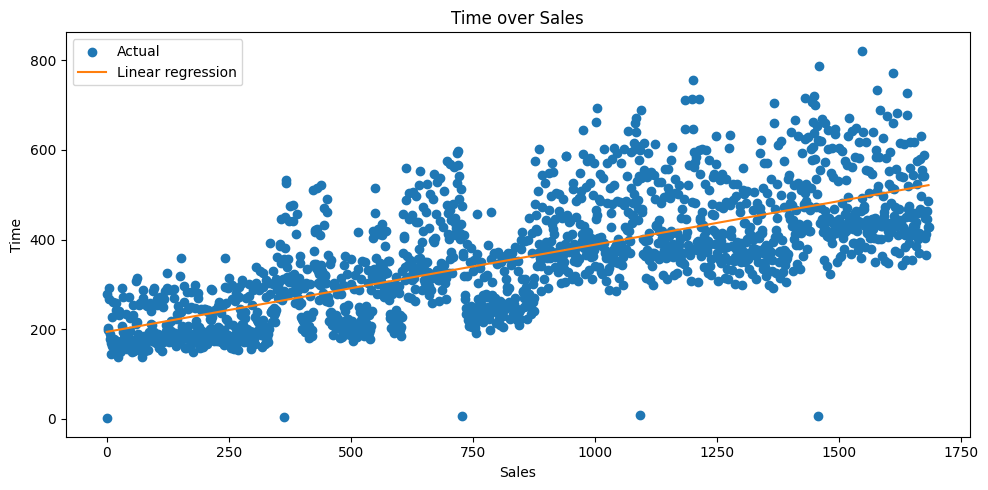

In [23]:
data = PreProcessor.avg_sales_with_timestep()
x = data.loc[:, ["time"]]
y = data.loc[:, "sales"]

model, y_pred, r2, p_value = LinRegression.run(x, y)
plt = ScatterPlot.plot(x, y, y_pred, "Sales", "Time")

print(f"R^2: {r2}")
print("F p-value: {:.3f}%".format(p_value * 100))
plt.show()

We estimate the model predicts 52% of the variance in average daily sales, and is statistically significant.

## Fit a lag feature to sales

We create a lag_1 for average daily sales.

R^2: 0.588110625743866
F p-value: 0.000%


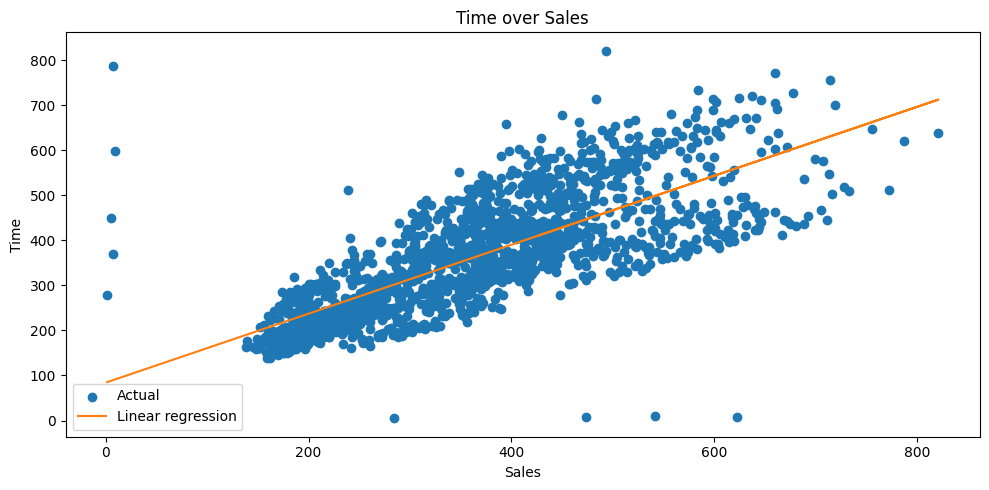

In [24]:
data = PreProcessor.avg_sales_with_timestep()
# Add a lag by 1 feature for avg sales
data["lag_1"] = data["sales"].shift(1)
# Remove the first day, as it has a NaN lag 1 value
x = data.loc[:, ["lag_1"]].iloc[1:]
y = data.loc[:, "sales"].iloc[1:]

model, y_pred, r2, p_value = LinRegression.run(x, y)
plt = ScatterPlot.plot(x, y, y_pred, "Sales", "Time")

print(f"R^2: {r2}")
print("F p-value: {:.3f}%".format(p_value * 100))
plt.show()

We've got a significant correlation explaining 59% of the variance. More sales yesterday predict more sales tomorrow.